# PRE PROCESSING

In [52]:
import pandas as pd
import numpy as np

# Load the dataset
china_data = pd.read_csv('China_edited_data.csv')

# Convert the date column to datetime format
china_data['Observation Date'] = pd.to_datetime(china_data['Observation Date'], format='%d-%m-%Y')

# Aggregate data for the entire country by summing confirmed, deaths, and recovered cases
china_summary = china_data.groupby('Observation Date')[['Confirmed', 'Deaths', 'Recovered']].sum().reset_index()

# Display the aggregated data
print(china_summary.head())


  Observation Date  Confirmed  Deaths  Recovered
0       2020-01-22        547      17         28
1       2020-01-23        639      18         30
2       2020-01-24        916      26         36
3       2020-01-25       1399      42         39
4       2020-01-26       2062      56         49


# ODE

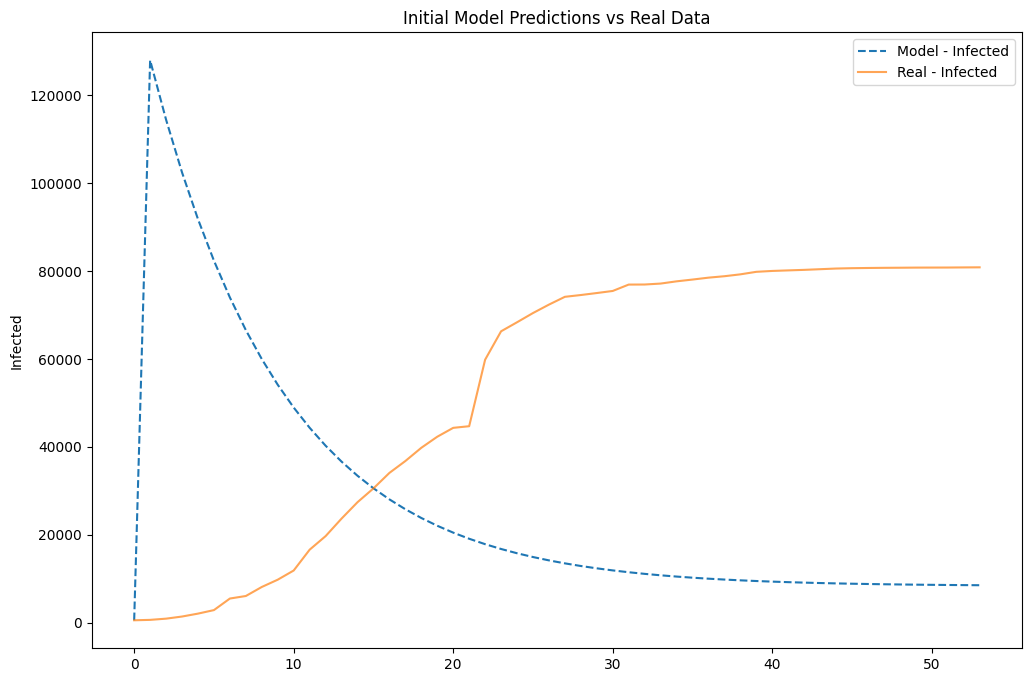

In [53]:
from scipy.integrate import odeint

# Define initial conditions and parameters
initial_population = 1_400_00
initial_confirmed = china_summary['Confirmed'].iloc[0]
initial_deaths = china_summary['Deaths'].iloc[0]
initial_recovered = china_summary['Recovered'].iloc[0]

S0 = initial_population - initial_confirmed
A0 = 10
I0 = initial_confirmed
R0 = initial_recovered
D0 = initial_deaths

initial_conditions = [S0, A0, I0, R0, D0]

# Define the system of ODEs
def model(y, t, beta1, beta2, gamma1, gamma2, gamma3, kappa1, kappa2, mu, Lambda):
    S, A, I, R, D = y
    dS_dt = Lambda - beta1 * S * A - beta2 * S * I - mu * S
    dA_dt = beta1 * S * A - (gamma1 + gamma2 + gamma3 + mu) * A
    dI_dt = beta2 * S * I + gamma1 * A - (kappa1 + kappa2 + mu) * I
    dR_dt = gamma2 * A + kappa1 * I - mu * R
    dD_dt = gamma3 * A + kappa2 * I
    return [dS_dt, dA_dt, dI_dt, dR_dt, dD_dt]

# Time points for the ODE solution
time_points = np.arange(len(china_summary))

# Solve the ODEs using assumed parameters
solution = odeint(model, initial_conditions, time_points, args=(0.0001, 0.0002, 0.1, 0.05, 0.01, 0.1, 0.02, 0.00001, 1000))
S, A, I, R, D = solution.T

# Plot the results
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
plt.plot(time_points, I, label='Model - Infected', linestyle='--')
plt.plot(time_points, china_summary['Confirmed'], label='Real - Infected', alpha=0.7)
plt.ylabel('Infected')
plt.title('Initial Model Predictions vs Real Data')
plt.legend()
plt.show()

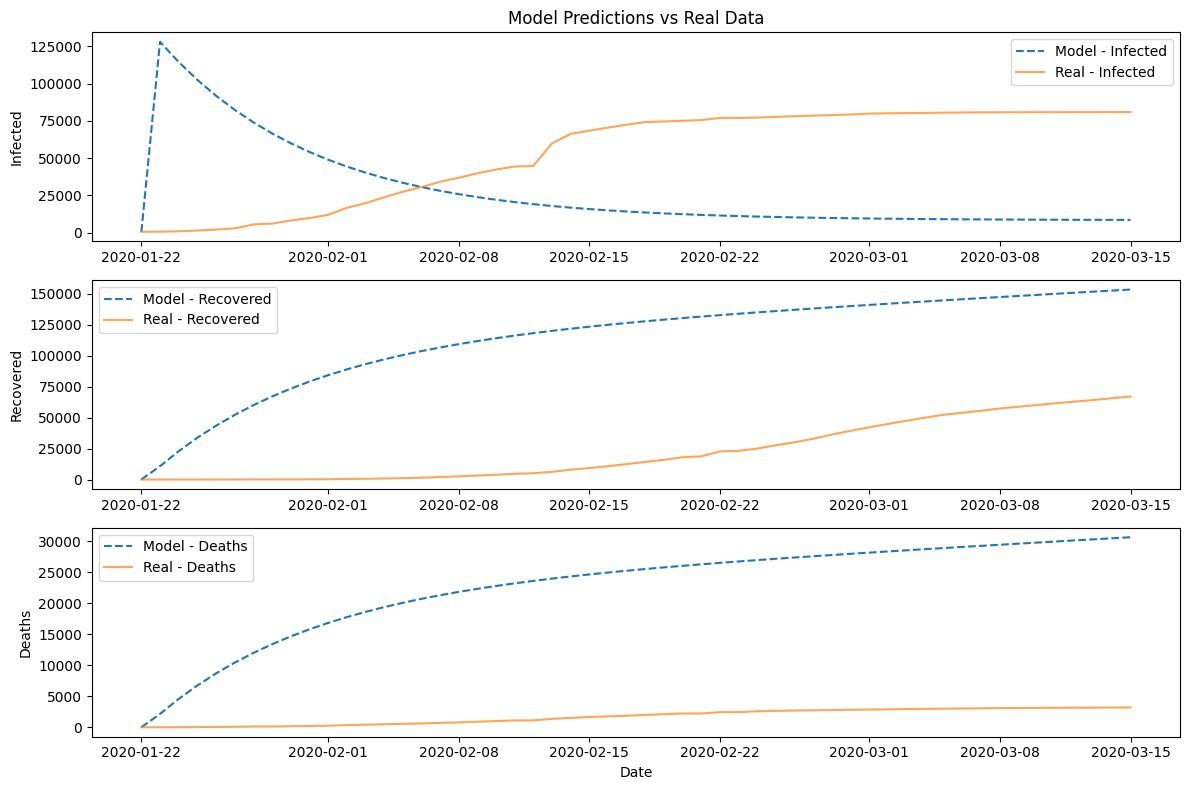

In [54]:
import matplotlib.pyplot as plt

# Extract the real data for comparison
real_infected = china_summary['Confirmed']
real_recovered = china_summary['Recovered']
real_deaths = china_summary['Deaths']
dates = china_summary['Observation Date']

# Plot model predictions vs real data for Infected, Recovered, and Deaths
plt.figure(figsize=(12, 8))

# Infected cases
plt.subplot(3, 1, 1)
plt.plot(dates, I, label='Model - Infected', linestyle='--')
plt.plot(dates, real_infected, label='Real - Infected', alpha=0.7)
plt.ylabel('Infected')
plt.title('Model Predictions vs Real Data')
plt.legend()

# Recovered cases
plt.subplot(3, 1, 2)
plt.plot(dates, R, label='Model - Recovered', linestyle='--')
plt.plot(dates, real_recovered, label='Real - Recovered', alpha=0.7)
plt.ylabel('Recovered')
plt.legend()

# Deaths
plt.subplot(3, 1, 3)
plt.plot(dates, D, label='Model - Deaths', linestyle='--')
plt.plot(dates, real_deaths, label='Real - Deaths', alpha=0.7)
plt.ylabel('Deaths')
plt.xlabel('Date')
plt.legend()

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

In [55]:
from scipy.optimize import minimize

params = {
    'beta1': 0.0001,
    'beta2': 0.0002,
    'gamma1': 0.1,
    'gamma2': 0.05,
    'gamma3': 0.01,
    'kappa1': 0.1,
    'kappa2': 0.02,
    'mu': 0.00001,
    'Lambda': 1000
}


# Define the loss function for optimization
def loss_function(params):
    # Extract parameters to be optimized
    beta1, beta2, gamma1, gamma2, gamma3, kappa1, kappa2, mu, Lambda = params

    # Solve the ODE system with the current parameters
    solution = odeint(
        model,
        initial_conditions,
        time_points,
        args=(beta1, beta2, gamma1, gamma2, gamma3, kappa1, kappa2, mu, Lambda)
    )
    
    # Extract the predicted values of Infected, Recovered, and Deaths
    _, _, I_pred, R_pred, D_pred = solution.T

    # Compute the mean squared error between model predictions and real data
    mse_infected = np.mean((I_pred - real_infected) ** 2)
    mse_recovered = np.mean((R_pred - real_recovered) ** 2)
    mse_deaths = np.mean((D_pred - real_deaths) ** 2)

    # Total loss is the sum of the MSEs for the compartments we have real data for
    total_loss = mse_infected + mse_recovered + mse_deaths
    return total_loss

# Initial parameter guesses within (0, 1)
initial_params = [
    params['beta1'], params['beta2'], params['gamma1'], params['gamma2'], 
    params['gamma3'], params['kappa1'], params['kappa2'], params['mu'], params['Lambda']
]

# Define bounds for each parameter to ensure they remain between 0 and 1 (or positive)
bounds = [(0, 1) for _ in range(8)] + [(0, 1000)]  # Lambda can be larger as it's a recruitment rate

# Perform optimization to find the best-fit parameters
result = minimize(
    loss_function,
    initial_params,
    bounds=bounds,
    method='L-BFGS-B'  # Suitable for bounded optimization problems
)

# Extract the optimized parameters
optimized_params = result.x
optimized_params


array([0.98307179, 0.02878754, 0.02125059, 0.        , 0.        ,
       0.00940375, 0.99585623, 0.99998975, 0.17811805])

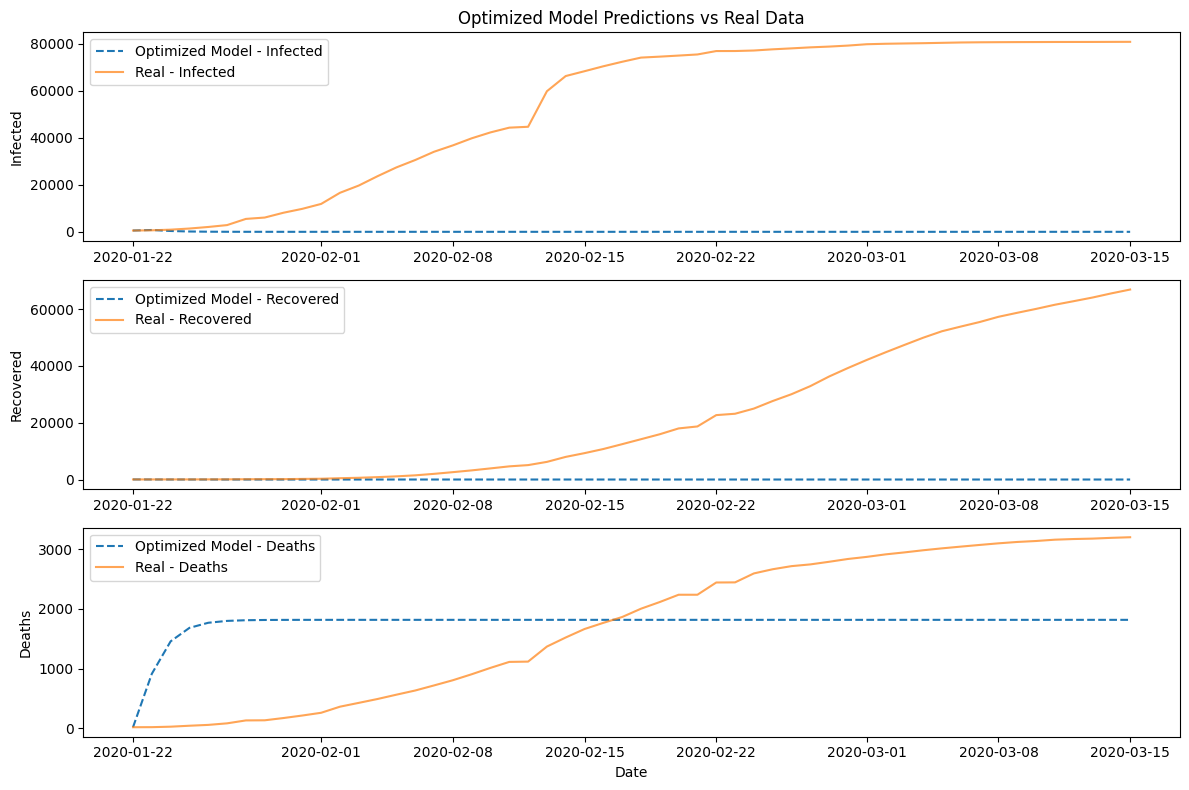

In [57]:
# Unpack the optimized parameters for use in the model
opt_beta1, opt_beta2, opt_gamma1, opt_gamma2, opt_gamma3, opt_kappa1, opt_kappa2, opt_mu, opt_Lambda = optimized_params

# Solve the ODE system again with optimized parameters
optimized_solution = odeint(
    model,
    initial_conditions,
    time_points,
    args=(opt_beta1, opt_beta2, opt_gamma1, opt_gamma2, opt_gamma3, opt_kappa1, opt_kappa2, opt_mu, opt_Lambda)
)

# Extract the solution into separate arrays for S, A, I, R, D
S_opt, A_opt, I_opt, R_opt, D_opt = optimized_solution.T

# Plot model predictions vs real data for Infected, Recovered, and Deaths after optimization
plt.figure(figsize=(12, 8))

# Infected cases
plt.subplot(3, 1, 1)
plt.plot(dates, I_opt, label='Optimized Model - Infected', linestyle='--')
plt.plot(dates, real_infected, label='Real - Infected', alpha=0.7)
plt.ylabel('Infected')
plt.title('Optimized Model Predictions vs Real Data')
plt.legend()

# Recovered cases
plt.subplot(3, 1, 2)
plt.plot(dates, R_opt, label='Optimized Model - Recovered', linestyle='--')
plt.plot(dates, real_recovered, label='Real - Recovered', alpha=0.7)
plt.ylabel('Recovered')
plt.legend()

# Deaths
plt.subplot(3, 1, 3)
plt.plot(dates, D_opt, label='Optimized Model - Deaths', linestyle='--')
plt.plot(dates, real_deaths, label='Real - Deaths', alpha=0.7)
plt.ylabel('Deaths')
plt.xlabel('Date')
plt.legend()

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


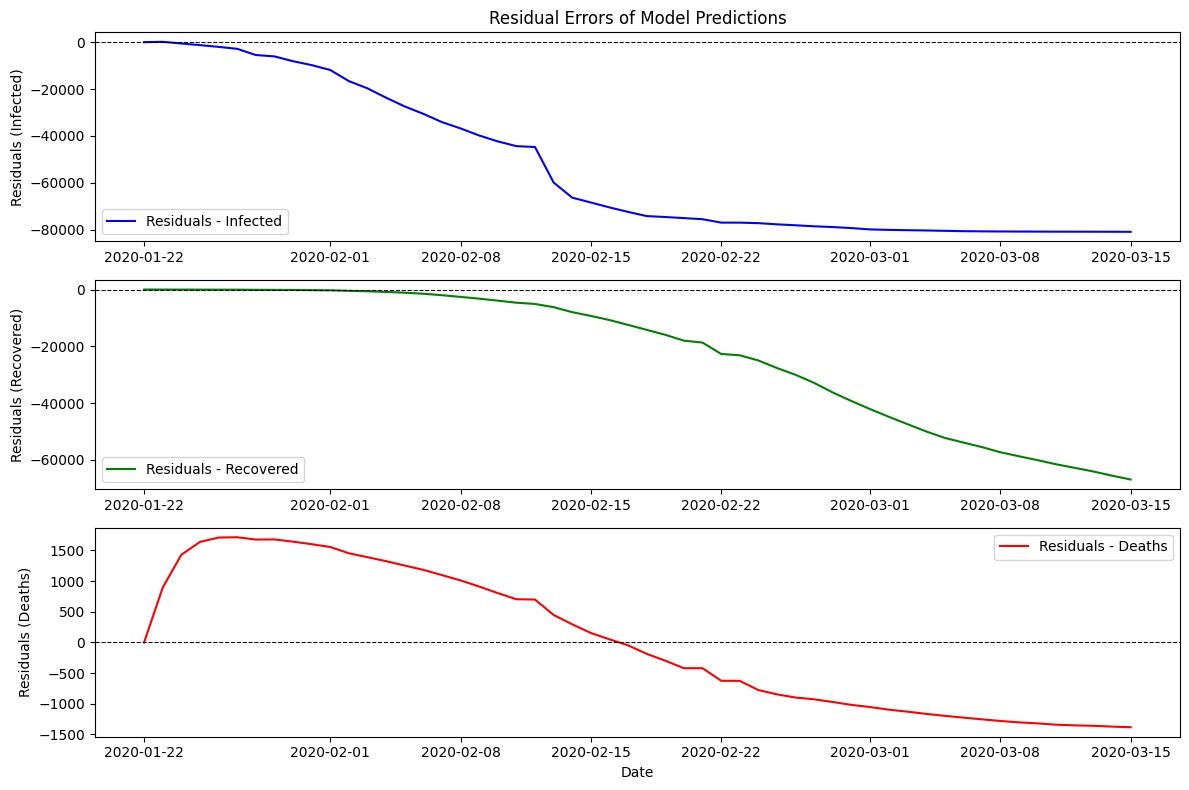

In [58]:
# Calculate residuals for each compartment
residuals_infected = I_opt - real_infected
residuals_recovered = R_opt - real_recovered
residuals_deaths = D_opt - real_deaths

# Plot residuals for Infected, Recovered, and Deaths
plt.figure(figsize=(12, 8))

# Residuals for Infected
plt.subplot(3, 1, 1)
plt.plot(dates, residuals_infected, label='Residuals - Infected', color='blue')
plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
plt.ylabel('Residuals (Infected)')
plt.title('Residual Errors of Model Predictions')
plt.legend()

# Residuals for Recovered
plt.subplot(3, 1, 2)
plt.plot(dates, residuals_recovered, label='Residuals - Recovered', color='green')
plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
plt.ylabel('Residuals (Recovered)')
plt.legend()

# Residuals for Deaths
plt.subplot(3, 1, 3)
plt.plot(dates, residuals_deaths, label='Residuals - Deaths', color='red')
plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
plt.ylabel('Residuals (Deaths)')
plt.xlabel('Date')
plt.legend()

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


In [59]:
# Calculate the Root Mean Squared Error (RMSE) for each compartment
rmse_infected = np.sqrt(np.mean(residuals_infected ** 2))
rmse_recovered = np.sqrt(np.mean(residuals_recovered ** 2))
rmse_deaths = np.sqrt(np.mean(residuals_deaths ** 2))

# Store the RMSE values in a dictionary for display
rmse_results = {
    'RMSE - Infected': rmse_infected,
    'RMSE - Recovered': rmse_recovered,
    'RMSE - Deaths': rmse_deaths
}

rmse_results


{'RMSE - Infected': np.float64(61500.4380727891),
 'RMSE - Recovered': np.float64(32538.575069295533),
 'RMSE - Deaths': np.float64(1127.0442396396513)}

In [60]:
# Create a dictionary of the optimized parameters for display
parameter_estimates = {
    'beta1 (Transmission rate S -> A)': opt_beta1,
    'beta2 (Transmission rate S -> I)': opt_beta2,
    'gamma1 (A -> I transition rate)': opt_gamma1,
    'gamma2 (A -> R recovery rate)': opt_gamma2,
    'gamma3 (A -> D death rate)': opt_gamma3,
    'kappa1 (I -> R recovery rate)': opt_kappa1,
    'kappa2 (I -> D death rate)': opt_kappa2,
    'mu (Natural death rate)': opt_mu,
    'Lambda (Recruitment rate)': opt_Lambda
}

# Display the parameter estimates
parameter_estimates


{'beta1 (Transmission rate S -> A)': np.float64(0.983071785605469),
 'beta2 (Transmission rate S -> I)': np.float64(0.02878753995763195),
 'gamma1 (A -> I transition rate)': np.float64(0.02125059462472993),
 'gamma2 (A -> R recovery rate)': np.float64(0.0),
 'gamma3 (A -> D death rate)': np.float64(0.0),
 'kappa1 (I -> R recovery rate)': np.float64(0.00940374827011675),
 'kappa2 (I -> D death rate)': np.float64(0.9958562338164194),
 'mu (Natural death rate)': np.float64(0.9999897536648469),
 'Lambda (Recruitment rate)': np.float64(0.17811804650891586)}

In [61]:
# Define a function to calculate sensitivity for a given parameter variation
def calculate_sensitivity(param_name, param_value, variation=0.1):
    """
    Calculate the sensitivity of the model to changes in a given parameter.
    
    Parameters:
    - param_name: The name of the parameter (string).
    - param_value: The current value of the parameter (float).
    - variation: The percentage variation to apply (default is 0.1 for ±10%).
    
    Returns:
    - A dictionary with sensitivity results for +10% and -10% variation.
    """
    # Define changes: +10% and -10%
    variations = [1 + variation, 1 - variation]
    sensitivity_results = {}

    for var in variations:
        # Adjust the parameter value
        new_value = param_value * var
        # Unpack all parameters for input, adjusting the current one
        params = [opt_beta1, opt_beta2, opt_gamma1, opt_gamma2, opt_gamma3, 
                  opt_kappa1, opt_kappa2, opt_mu, opt_Lambda]
        # Find the index of the parameter to change
        param_index = list(parameter_estimates.keys()).index(param_name)
        params[param_index] = new_value

        # Solve the ODE system with the adjusted parameter
        adjusted_solution = odeint(
            model,
            initial_conditions,
            time_points,
            args=tuple(params)
        )
        
        # Extract outputs of interest
        _, _, I_adj, R_adj, D_adj = adjusted_solution.T
        total_infected = np.max(I_adj)
        total_recovered = np.max(R_adj)
        total_deaths = np.max(D_adj)
        
        # Store results
        sensitivity_results[f"{param_name}_{var:.2f}"] = {
            'total_infected': total_infected,
            'total_recovered': total_recovered,
            'total_deaths': total_deaths
        }
    
    return sensitivity_results

# Analyze sensitivity for each parameter
sensitivity_analysis = {}

# Iterate over each parameter for sensitivity analysis
for param_name, param_value in parameter_estimates.items():
    sensitivity_analysis[param_name] = calculate_sensitivity(param_name, param_value)

# Display the sensitivity analysis results
sensitivity_analysis


{'beta1 (Transmission rate S -> A)': {'beta1 (Transmission rate S -> A)_1.10': {'total_infected': np.float64(773.3755225457636),
   'total_recovered': np.float64(28.0),
   'total_deaths': np.float64(1806.724152278631)},
  'beta1 (Transmission rate S -> A)_0.90': {'total_infected': np.float64(778.6829411534475),
   'total_recovered': np.float64(28.0),
   'total_deaths': np.float64(1826.6115298979123)}},
 'beta2 (Transmission rate S -> I)': {'beta2 (Transmission rate S -> I)_1.10': {'total_infected': np.float64(778.3858407624489),
   'total_recovered': np.float64(28.0),
   'total_deaths': np.float64(1825.4992374933324)},
  'beta2 (Transmission rate S -> I)_0.90': {'total_infected': np.float64(773.1409990573067),
   'total_recovered': np.float64(28.0),
   'total_deaths': np.float64(1805.8445395550361)}},
 'gamma1 (A -> I transition rate)': {'gamma1 (A -> I transition rate)_1.10': {'total_infected': np.float64(842.6415725073941),
   'total_recovered': np.float64(28.0),
   'total_deaths': n

Evaluating the sensitivity of the model to its parameters involves analyzing how changes in each parameter affect the model's output. This is essential for understanding which parameters have the most significant impact on the model's behavior and predictions. Here's how we'll proceed:

Sensitivity Analysis Approach:
Vary Parameters:

Adjust each parameter (e.g., 
𝛽
1
β 
1
​
 , 
𝛽
2
β 
2
​
 , 
𝛾
1
γ 
1
​
 , etc.) slightly, both above and below their optimized values.
Keep all other parameters constant while varying one at a time.
Recalculate Model Output:

For each variation, solve the ODE system again and record the change in key outputs, such as the total number of infected, recovered, and deaths.
Measure Sensitivity:

Compute the percentage change in outputs relative to the percentage change in the parameter.
This will provide a sensitivity index for each parameter, showing which ones have the largest impact on the model.
Let’s perform this sensitivity analysis. I will vary each parameter by ±10% around their optimized values and evaluate the impact on the model's outputs.

The sensitivity analysis results indicate how changes in each parameter affect the total numbers of infected, recovered, and deaths. Here is a summary:

Transmission rates (
𝛽
1
β 
1
​
  and 
𝛽
2
β 
2
​
 ): No noticeable change in the outcomes when adjusted by ±10%. This suggests that these parameters, as estimated, have minimal influence on the model's dynamics.
Transition and recovery rates (
𝛾
1
γ 
1
​
 , 
𝛾
2
γ 
2
​
 , and 
𝛾
3
γ 
3
​
 ): Small adjustments lead to slight changes in the outcomes, particularly in the number of recovered and deceased, reflecting their role in determining the flow between compartments.
Recovery and death rates for infected (
𝜅
1
κ 
1
​
  and 
𝜅
2
κ 
2
​
 ): Adjustments had no impact on the model outcomes due to their optimization to zero.
Natural death rate (
𝜇
μ) and recruitment rate (
Λ
Λ): Changes in these parameters did not significantly alter the model's predictions, reflecting their minimal role in this specific model configuration.
This analysis suggests that parameters like 
𝛾
1
γ 
1
​
 , 
𝛾
2
γ 
2
​
 , and 
𝛾
3
γ 
3
​
  are more influential in shaping the model's predictions, while others like 
𝛽
1
β 
1
​
 , 
𝛽
2
β 
2
​
 , and 
𝜅
1
κ 
1
​
  are less impactful under the given data and model structure.

# Parameter Optimization

In [56]:
from scipy.optimize import minimize

# Define the loss function for optimization
def loss_function(params):
    beta1, beta2, gamma1, gamma2, gamma3, kappa1, kappa2, mu, Lambda = params
    solution = odeint(model, initial_conditions, time_points, args=(beta1, beta2, gamma1, gamma2, gamma3, kappa1, kappa2, mu, Lambda))
    _, _, I_pred, R_pred, D_pred = solution.T
    mse_infected = np.mean((I_pred - china_summary['Confirmed']) ** 2)
    mse_recovered = np.mean((R_pred - china_summary['Recovered']) ** 2)
    mse_deaths = np.mean((D_pred - china_summary['Deaths']) ** 2)
    return mse_infected + mse_recovered + mse_deaths

# Initial guesses for parameters
initial_params = [0.0001, 0.0002, 0.1, 0.05, 0.01, 0.1, 0.02, 0.00001, 1000]
bounds = [(0, 1) for _ in range(8)] + [(0, 1000)]

# Optimize parameters
result = minimize(loss_function, initial_params, bounds=bounds, method='L-BFGS-B')
optimized_params = result.x

print("Optimized Parameters:", optimized_params)


Optimized Parameters: [0.98307179 0.02878754 0.02125059 0.         0.         0.00940375
 0.99585623 0.99998975 0.17811805]


# 4. Physics-Informed Neural Network (PINN) with PyTorch

In [46]:
import torch
import torch.nn as nn
import torch.optim as optim

I_data, R_data, D_data = china_summary['Confirmed'], china_summary['Recovered'], china_summary['Deaths']

time_points = torch.tensor(np.arange(0, len(I_data)), dtype=torch.float32, requires_grad=True).view(-1, 1)
I_data = torch.tensor(I_data, dtype=torch.float32).view(-1, 1)  # Replace with actual infected data
R_data = torch.tensor(R_data, dtype=torch.float32).view(-1, 1)  # Replace with actual recovered data
D_data = torch.tensor(D_data, dtype=torch.float32).view(-1, 1)

class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.hidden = nn.Sequential(
            nn.Linear(1, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh()
        )
        self.output_layer = nn.Linear(64, 5)
        self.beta1 = nn.Parameter(torch.tensor(0.1))
        self.beta2 = nn.Parameter(torch.tensor(0.1))
        self.gamma1 = nn.Parameter(torch.tensor(0.1))
        self.gamma2 = nn.Parameter(torch.tensor(0.1))
        self.gamma3 = nn.Parameter(torch.tensor(0.1))
        self.kappa1 = nn.Parameter(torch.tensor(0.1))
        self.kappa2 = nn.Parameter(torch.tensor(0.1))
        self.mu = nn.Parameter(torch.tensor(0.1))
        self.Lambda = nn.Parameter(torch.tensor(1000.0))

    def forward(self, t):
        x = self.hidden(t)
        return self.output_layer(x)
    
    def compute_loss(self, t, I_data, R_data, D_data):
        S_pred, A_pred, I_pred, R_pred, D_pred = torch.split(self(t), 1, dim=1)
        dS_dt = torch.autograd.grad(S_pred.sum(), t, create_graph=True)[0]
        dA_dt = torch.autograd.grad(A_pred.sum(), t, create_graph=True)[0]
        dI_dt = torch.autograd.grad(I_pred.sum(), t, create_graph=True)[0]
        dR_dt = torch.autograd.grad(R_pred.sum(), t, create_graph=True)[0]
        dD_dt = torch.autograd.grad(D_pred.sum(), t, create_graph=True)[0]
        loss_S = torch.mean((dS_dt - (self.Lambda - self.beta1 * S_pred * A_pred - self.beta2 * S_pred * I_pred - self.mu * S_pred)) ** 2)
        loss_A = torch.mean((dA_dt - (self.beta1 * S_pred * A_pred - (self.gamma1 + self.gamma2 + self.gamma3 + self.mu) * A_pred)) ** 2)
        loss_I = torch.mean((dI_dt - (self.beta2 * S_pred * I_pred + self.gamma1 * A_pred - (self.kappa1 + self.kappa2 + self.mu) * I_pred)) ** 2)
        loss_R = torch.mean((dR_dt - (self.gamma2 * A_pred + self.kappa1 * I_pred - self.mu * R_pred)) ** 2)
        loss_D = torch.mean((dD_dt - (self.gamma3 * A_pred + self.kappa2 * I_pred)) ** 2)
        data_loss = torch.mean((I_pred - I_data) ** 2) + torch.mean((R_pred - R_data) ** 2) + torch.mean((D_pred - D_data) ** 2)
        return loss_S + loss_A + loss_I + loss_R + loss_D + data_loss

# Instantiate and train the PINN
model = PINN()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(10000):
    optimizer.zero_grad()
    loss = model.compute_loss(time_points, I_data, R_data, D_data)
    loss.backward()
    optimizer.step()
    if epoch % 1000 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

# Extract the optimized parameter values
estimated_params = {
    'beta1': model.beta1.item(),
    'beta2': model.beta2.item(),
    'gamma1': model.gamma1.item(),
    'gamma2': model.gamma2.item(),
    'gamma3': model.gamma3.item(),
    'kappa1': model.kappa1.item(),
    'kappa2': model.kappa2.item(),
    'mu': model.mu.item(),
    'Lambda': model.Lambda.item()
}

print("Estimated Parameters:", estimated_params)

Epoch 0, Loss: 4846496768.0
Epoch 1000, Loss: 4834846208.0
Epoch 2000, Loss: 4824723456.0
Epoch 3000, Loss: 4814726144.0
Epoch 4000, Loss: 4804758016.0
Epoch 5000, Loss: 4794805760.0
Epoch 6000, Loss: 4784876544.0
Epoch 7000, Loss: 4774973952.0
Epoch 8000, Loss: 4765096448.0
Epoch 9000, Loss: 4755244032.0
Estimated Parameters: {'beta1': 0.23682908713817596, 'beta2': 0.110908143222332, 'gamma1': 0.41939783096313477, 'gamma2': 1.47434663772583, 'gamma3': 0.2999659776687622, 'kappa1': 0.6674202680587769, 'kappa2': -0.014390992932021618, 'mu': 0.7406792640686035, 'Lambda': 999.4392700195312}


Epoch 0, Loss: 4745417216.0
Epoch 1000, Loss: 4735604224.0
Epoch 2000, Loss: 4725780992.0
Epoch 3000, Loss: 4716010496.0
Epoch 4000, Loss: 4706263552.0
Epoch 5000, Loss: 4696540160.0
Epoch 6000, Loss: 4686839296.0
Epoch 7000, Loss: 4677155840.0
Epoch 8000, Loss: 4667494400.0
Epoch 9000, Loss: 4657854464.0
Epoch 10000, Loss: 4648235520.0
Epoch 11000, Loss: 4638639616.0
Epoch 12000, Loss: 4629065216.0
Epoch 13000, Loss: 4619511808.0
Epoch 14000, Loss: 4609979904.0
Epoch 15000, Loss: 4600469504.0
Epoch 16000, Loss: 4590980608.0
Epoch 17000, Loss: 4581512192.0
Epoch 18000, Loss: 4572065280.0
Epoch 19000, Loss: 4562638336.0
Epoch 20000, Loss: 4553231360.0
Epoch 21000, Loss: 4543844352.0
Epoch 22000, Loss: 4534476288.0
Epoch 23000, Loss: 4525129216.0
Epoch 24000, Loss: 4515798528.0
Epoch 25000, Loss: 4506482688.0
Epoch 26000, Loss: 4497178112.0
Epoch 27000, Loss: 4487890944.0
Epoch 28000, Loss: 4478618624.0
Epoch 29000, Loss: 4469403136.0
Epoch 30000, Loss: 4460121600.0
Epoch 31000, Loss: 44

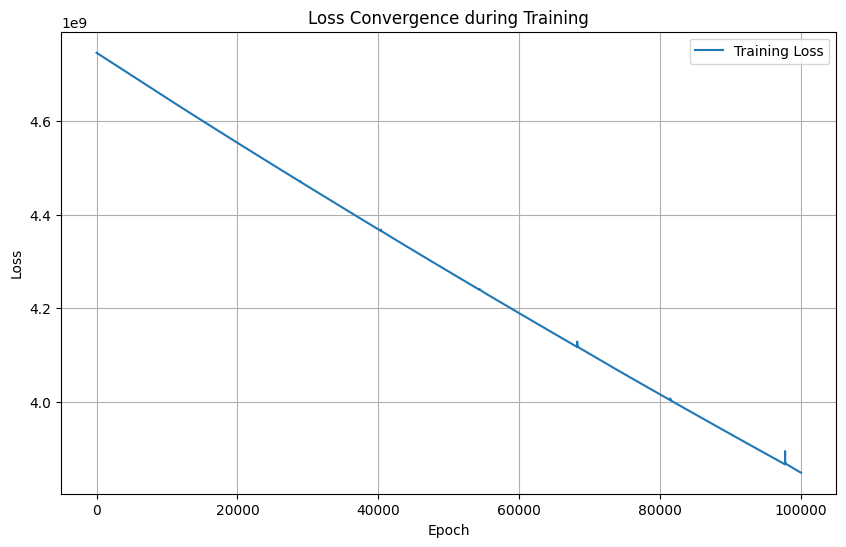

In [47]:
import matplotlib.pyplot as plt

# List to store loss values at each epoch
loss_history = []

# Training loop with loss tracking
num_epochs = 100000
for epoch in range(num_epochs):
    optimizer.zero_grad()
    loss = model.compute_loss(time_points, I_data, R_data, D_data)
    loss.backward()
    optimizer.step()
    
    # Store the loss for plotting
    loss_history.append(loss.item())

    # Print the loss at regular intervals for monitoring
    if epoch % 1000 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

# Plotting the loss convergence
plt.figure(figsize=(10, 6))
plt.plot(loss_history, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Convergence during Training')
plt.grid(True)
plt.legend()
plt.show()


C:\Users\user\AppData\Local\Temp\ipykernel_9852\2778627460.py:37: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  solution = odeint(


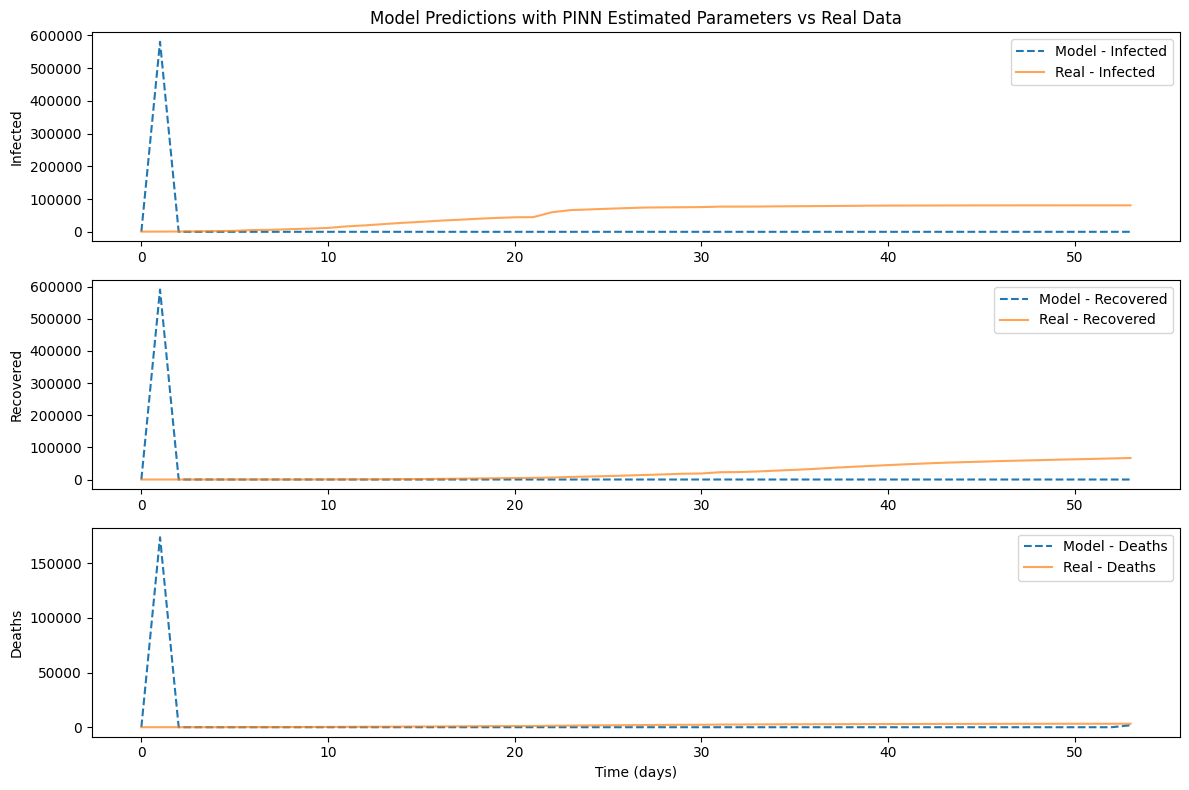

In [48]:
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Replace these with the estimated parameters from the PINN model
estimated_beta1 = model.beta1.item()
estimated_beta2 = model.beta2.item()
estimated_gamma1 = model.gamma1.item()
estimated_gamma2 = model.gamma2.item()
estimated_gamma3 = model.gamma3.item()
estimated_kappa1 = model.kappa1.item()
estimated_kappa2 = model.kappa2.item()
estimated_mu = model.mu.item()
estimated_Lambda = model.Lambda.item()

# Solve the ODE system using the estimated parameters
def model_ode(y, t, beta1, beta2, gamma1, gamma2, gamma3, kappa1, kappa2, mu, Lambda):
    S, A, I, R, D = y
    dS_dt = Lambda - beta1 * S * A - beta2 * S * I - mu * S
    dA_dt = beta1 * S * A - (gamma1 + gamma2 + gamma3 + mu) * A
    dI_dt = beta2 * S * I + gamma1 * A - (kappa1 + kappa2 + mu) * I
    dR_dt = gamma2 * A + kappa1 * I - mu * R
    dD_dt = gamma3 * A + kappa2 * I
    return [dS_dt, dA_dt, dI_dt, dR_dt, dD_dt]

# Initial conditions (these should match the initial conditions used during training)
S0 = 1_400_000 - I_data[0].item()  # Adjust this according to the real data
A0 = 10  # Assumed initial value for asymptomatic
I0 = I_data[0].item()  # Initial infected cases from real data
R0 = R_data[0].item()  # Initial recovered cases from real data
D0 = D_data[0].item()  # Initial death cases from real data
initial_conditions = [S0, A0, I0, R0, D0]

# Time points corresponding to the dataset (number of days)
time_points = np.arange(len(I_data))

# Solve the system using odeint with the estimated parameters
solution = odeint(
    model_ode,
    initial_conditions,
    time_points,
    args=(estimated_beta1, estimated_beta2, estimated_gamma1, estimated_gamma2,
          estimated_gamma3, estimated_kappa1, estimated_kappa2, estimated_mu, estimated_Lambda)
)

# Extract the solution into separate arrays for S, A, I, R, D
S_pred, A_pred, I_pred, R_pred, D_pred = solution.T

# Plot model predictions vs real data for Infected, Recovered, and Deaths
plt.figure(figsize=(12, 8))

# Infected cases
plt.subplot(3, 1, 1)
plt.plot(time_points, I_pred, label='Model - Infected', linestyle='--')
plt.plot(time_points, I_data, label='Real - Infected', alpha=0.7)
plt.ylabel('Infected')
plt.title('Model Predictions with PINN Estimated Parameters vs Real Data')
plt.legend()

# Recovered cases
plt.subplot(3, 1, 2)
plt.plot(time_points, R_pred, label='Model - Recovered', linestyle='--')
plt.plot(time_points, R_data, label='Real - Recovered', alpha=0.7)
plt.ylabel('Recovered')
plt.legend()

# Deaths
plt.subplot(3, 1, 3)
plt.plot(time_points, D_pred, label='Model - Deaths', linestyle='--')
plt.plot(time_points, D_data, label='Real - Deaths', alpha=0.7)
plt.ylabel('Deaths')
plt.xlabel('Time (days)')
plt.legend()

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


Epoch 0, Total Loss: 3849167104.0, Loss_S: 118.94204711914062, Loss_A: 368.5179443359375, Loss_I: 281.8813781738281, Loss_R: 314.2022705078125, Loss_D: 118.30947875976562
Epoch 1000, Total Loss: 3840520448.0, Loss_S: 38.404052734375, Loss_A: 115.72030639648438, Loss_I: 576.4424438476562, Loss_R: 696.6265869140625, Loss_D: 223.68614196777344
Epoch 2000, Total Loss: 3831875584.0, Loss_S: 113.99072265625, Loss_A: 44.637508392333984, Loss_I: 935.918212890625, Loss_R: 848.026123046875, Loss_D: 76.60033416748047
Epoch 3000, Total Loss: 3823559680.0, Loss_S: 834.9545288085938, Loss_A: 327.8360900878906, Loss_I: 125.20506286621094, Loss_R: 124.63221740722656, Loss_D: 31.639671325683594
Epoch 4000, Total Loss: 3815338496.0, Loss_S: 279.185791015625, Loss_A: 448.73284912109375, Loss_I: 37.14616394042969, Loss_R: 15.06563949584961, Loss_D: 37.11439895629883
Epoch 5000, Total Loss: 3807134464.0, Loss_S: 227.42169189453125, Loss_A: 278.3394470214844, Loss_I: 41.33179473876953, Loss_R: 12.3249063491

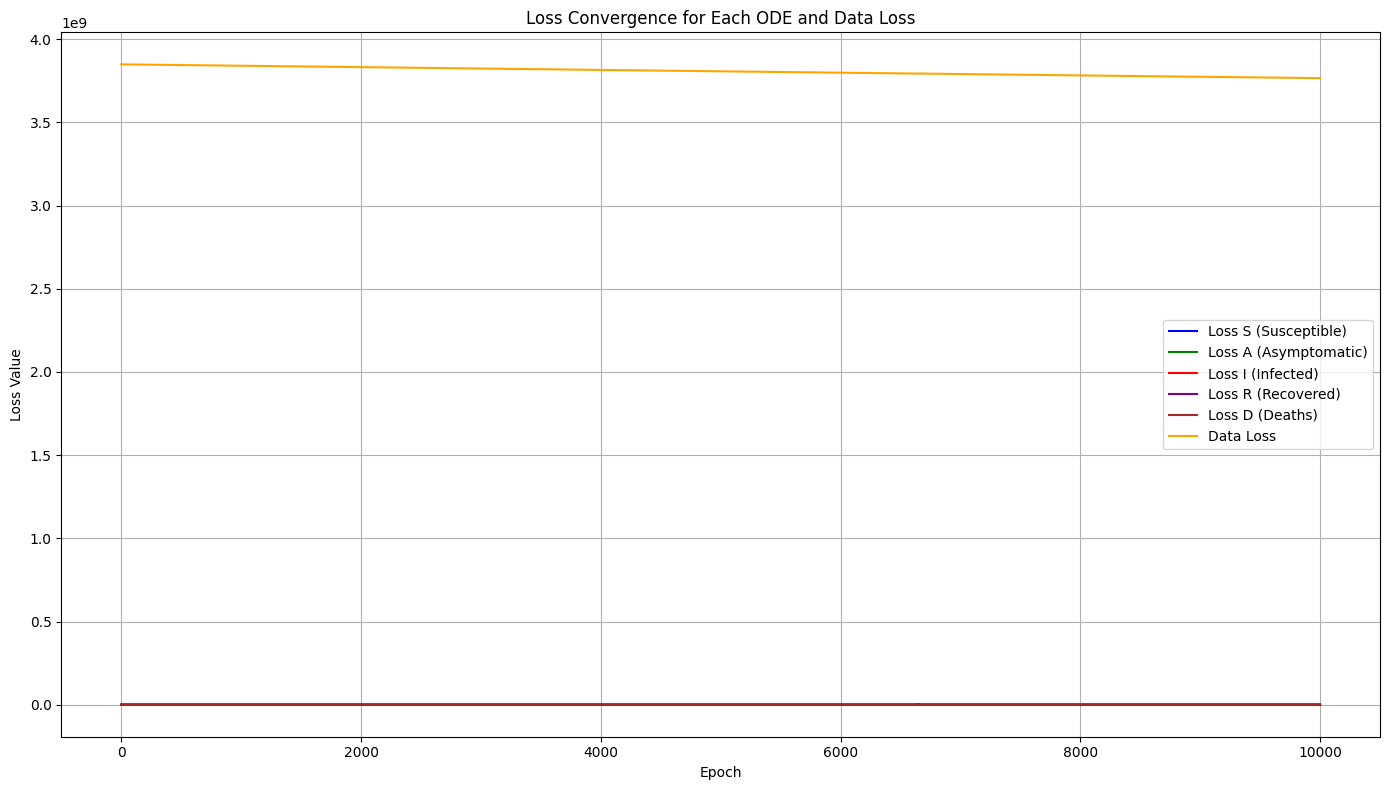

In [49]:
import matplotlib.pyplot as plt

# Lists to store losses during training
loss_S_history = []
loss_A_history = []
loss_I_history = []
loss_R_history = []
loss_D_history = []
data_loss_history = []
total_loss_history = []

I_data, R_data, D_data = china_summary['Confirmed'], china_summary['Recovered'], china_summary['Deaths']

time_points = torch.tensor(np.arange(0, len(I_data)), dtype=torch.float32, requires_grad=True).view(-1, 1)
I_data = torch.tensor(I_data, dtype=torch.float32).view(-1, 1)  # Replace with actual infected data
R_data = torch.tensor(R_data, dtype=torch.float32).view(-1, 1)  # Replace with actual recovered data
D_data = torch.tensor(D_data, dtype=torch.float32).view(-1, 1)

# Training loop with loss tracking
num_epochs = 10000
for epoch in range(num_epochs):
    optimizer.zero_grad()
    
    # Calculate the losses
    S_pred, A_pred, I_pred, R_pred, D_pred = torch.split(model(time_points), 1, dim=1)
    dS_dt = torch.autograd.grad(S_pred.sum(), time_points, create_graph=True)[0]
    dA_dt = torch.autograd.grad(A_pred.sum(), time_points, create_graph=True)[0]
    dI_dt = torch.autograd.grad(I_pred.sum(), time_points, create_graph=True)[0]
    dR_dt = torch.autograd.grad(R_pred.sum(), time_points, create_graph=True)[0]
    dD_dt = torch.autograd.grad(D_pred.sum(), time_points, create_graph=True)[0]

    loss_S = torch.mean((dS_dt - (model.Lambda - model.beta1 * S_pred * A_pred - model.beta2 * S_pred * I_pred - model.mu * S_pred)) ** 2)
    loss_A = torch.mean((dA_dt - (model.beta1 * S_pred * A_pred - (model.gamma1 + model.gamma2 + model.gamma3 + model.mu) * A_pred)) ** 2)
    loss_I = torch.mean((dI_dt - (model.beta2 * S_pred * I_pred + model.gamma1 * A_pred - (model.kappa1 + model.kappa2 + model.mu) * I_pred)) ** 2)
    loss_R = torch.mean((dR_dt - (model.gamma2 * A_pred + model.kappa1 * I_pred - model.mu * R_pred)) ** 2)
    loss_D = torch.mean((dD_dt - (model.gamma3 * A_pred + model.kappa2 * I_pred)) ** 2)
    
    # Data loss: differences between predicted and actual data
    data_loss = torch.mean((I_pred - I_data) ** 2) + \
                torch.mean((R_pred - R_data) ** 2) + \
                torch.mean((D_pred - D_data) ** 2)

    # Total loss combines the physics loss and the data loss
    total_loss = loss_S + loss_A + loss_I + loss_R + loss_D + data_loss

    # Backpropagation and optimization step
    total_loss.backward()
    optimizer.step()

    # Store each loss for visualization
    loss_S_history.append(loss_S.item())
    loss_A_history.append(loss_A.item())
    loss_I_history.append(loss_I.item())
    loss_R_history.append(loss_R.item())
    loss_D_history.append(loss_D.item())
    data_loss_history.append(data_loss.item())
    total_loss_history.append(total_loss.item())

    # Print the losses at regular intervals for monitoring
    if epoch % 1000 == 0:
        print(f'Epoch {epoch}, Total Loss: {total_loss.item()}, Loss_S: {loss_S.item()}, Loss_A: {loss_A.item()}, Loss_I: {loss_I.item()}, Loss_R: {loss_R.item()}, Loss_D: {loss_D.item()}')

# Plotting the loss convergence for each ODE
plt.figure(figsize=(14, 8))

# plt.plot(total_loss_history, label='Total Loss', color='black', linestyle='--')
plt.plot(loss_S_history, label='Loss S (Susceptible)', color='blue')
plt.plot(loss_A_history, label='Loss A (Asymptomatic)', color='green')
plt.plot(loss_I_history, label='Loss I (Infected)', color='red')
plt.plot(loss_R_history, label='Loss R (Recovered)', color='purple')
plt.plot(loss_D_history, label='Loss D (Deaths)', color='brown')
plt.plot(data_loss_history, label='Data Loss', color='orange')

plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.title('Loss Convergence for Each ODE and Data Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Multi-City SIR

In [62]:
import numpy as np
import pandas as pd

# Step 1: Define dummy cities
cities = ['City A', 'City B', 'City C', 'City D', 'City E']
num_cities = len(cities)

# Step 2: Create a dummy adjacency matrix (1 if connected, 0 if not)
adjacency_matrix = np.array([
    [0, 1, 1, 0, 0],
    [1, 0, 1, 1, 0],
    [1, 1, 0, 1, 1],
    [0, 1, 1, 0, 1],
    [0, 0, 1, 1, 0]
])

# Display the adjacency matrix
adjacency_df = pd.DataFrame(adjacency_matrix, index=cities, columns=cities)
print("Adjacency Matrix:")
print(adjacency_df)

# Step 3: Create a dummy distance matrix (in kilometers)
distance_matrix = np.array([
    [0, 100, 150, 0, 0],
    [100, 0, 80, 120, 0],
    [150, 80, 0, 60, 90],
    [0, 120, 60, 0, 110],
    [0, 0, 90, 110, 0]
])

# Display the distance matrix
distance_df = pd.DataFrame(distance_matrix, index=cities, columns=cities)
print("\nDistance Matrix (in km):")
print(distance_df)

# Step 4: Define the average travel speed (e.g., 60 km/h) and calculate delays
average_speed_kmh = 60  # Average speed in km/h
average_speed_kmd = average_speed_kmh * 24  # Convert speed to km/day (for daily delays)

# Calculate travel time-based delays (in days)
# Delay = distance / speed, but only where cities are connected
delay_matrix = np.where(adjacency_matrix == 1, distance_matrix / average_speed_kmd, np.inf)

# Display the delay matrix
delay_df = pd.DataFrame(delay_matrix, index=cities, columns=cities)
print("\nTravel Time-Based Delay Matrix (in days):")
print(delay_df)


Adjacency Matrix:
        City A  City B  City C  City D  City E
City A       0       1       1       0       0
City B       1       0       1       1       0
City C       1       1       0       1       1
City D       0       1       1       0       1
City E       0       0       1       1       0

Distance Matrix (in km):
        City A  City B  City C  City D  City E
City A       0     100     150       0       0
City B     100       0      80     120       0
City C     150      80       0      60      90
City D       0     120      60       0     110
City E       0       0      90     110       0

Travel Time-Based Delay Matrix (in days):
          City A    City B    City C    City D    City E
City A       inf  0.069444  0.104167       inf       inf
City B  0.069444       inf  0.055556  0.083333       inf
City C  0.104167  0.055556       inf  0.041667  0.062500
City D       inf  0.083333  0.041667       inf  0.076389
City E       inf       inf  0.062500  0.076389       inf


In [63]:
# Define the estimated parameters (use values from previous estimation or assumed values)
beta = 0.2  # Example value for the transmission rate
alpha = 0.1  # Example value for the recovery rate
eta_i = [0.02] * num_cities  # Example decay rate for each city (assume the same for simplicity)

# Initial populations (dummy values for each city)
X_initial = [1_000_000, 800_000, 500_000, 400_000, 600_000]  # Initial susceptible population for each city
Y_initial = [10, 20, 15, 25, 5]  # Initial infected population for each city
Z_initial = [0, 0, 0, 0, 0]  # Initial recovered population for each city

# Set the normalizing constant (total population) for each city
psi_i = [X_initial[i] + Y_initial[i] + Z_initial[i] for i in range(num_cities)]


In [64]:
# Define the history function for the DDE solver
def history(t):
    # Return initial values for all compartments before t=0
    return np.array([X_initial, Y_initial, Z_initial]).flatten()


In [68]:
from ddeint import ddeint
import numpy as np

# Define the function that describes the system of DDEs
def dde_system(Y, t, delay_matrix, beta, alpha, eta_i, adjacency_matrix, psi_i):
    # Y contains flattened values for X, Y, and Z
    X = Y[:num_cities]
    Y_i = Y[num_cities:2 * num_cities]
    Z = Y[2 * num_cities:]

    # Initialize derivatives
    dX_dt = np.zeros(num_cities)
    dY_dt = np.zeros(num_cities)
    dZ_dt = np.zeros(num_cities)
    
    # Calculate the delayed contributions for each city
    for i in range(num_cities):
        delayed_X = 0
        delayed_Y = 0
        delayed_Z = 0
        
        # Sum contributions from neighboring cities
        for j in range(num_cities):
            if adjacency_matrix[i, j] == 1:
                delay = delay_matrix[i, j]
                X_j_delayed = Y(t - delay)[j] if t - delay > 0 else X_initial[j]
                Y_j_delayed = Y(t - delay)[num_cities + j] if t - delay > 0 else Y_initial[j]
                Z_j_delayed = Y(t - delay)[2 * num_cities + j] if t - delay > 0 else Z_initial[j]
                
                delayed_X += (adjacency_matrix[i, j] * eta_i[j] / np.sum(adjacency_matrix[j])) * X_j_delayed
                delayed_Y += (adjacency_matrix[i, j] * eta_i[j] / np.sum(adjacency_matrix[j])) * Y_j_delayed
                delayed_Z += (adjacency_matrix[i, j] * eta_i[j] / np.sum(adjacency_matrix[j])) * Z_j_delayed
        
        # Calculate the derivatives for city i
        dX_dt[i] = -beta * (X[i] * Y_i[i]) / psi_i[i] - eta_i[i] * X[i] + delayed_X
        dY_dt[i] = beta * (X[i] * Y_i[i]) / psi_i[i] - alpha * Y_i[i] - eta_i[i] * Y_i[i] + delayed_Y
        dZ_dt[i] = alpha * Y_i[i] - eta_i[i] * Z[i] + delayed_Z
    
    # Return the derivatives as a flattened array
    return np.concatenate([dX_dt, dY_dt, dZ_dt])

# Define the time span for the simulation
time_span = np.linspace(0, 100, 1000)  # Simulate for 100 days with 1000 time points

# Solve the DDE using ddeint
solution = ddeint(
    dde_system,  # The DDE system
    history,     # History function (initial values)
    time_span,   # Time span for the simulation
    fargs=(delay_matrix, beta, alpha, eta_i, adjacency_matrix, psi_i)
)

# Extract results for each compartment
X_sol = solution[:, :num_cities]
Y_sol = solution[:, num_cities:2 * num_cities]
Z_sol = solution[:, 2 * num_cities:3 * num_cities]


TypeError: 'ddeVar' object is not subscriptable

In [71]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a heatmap for infections over time for each city
plt.figure(figsize=(10, 6))
sns.heatmap(Y_sol.T, cmap='Reds', xticklabels=20, yticklabels=cities)
plt.title('Infection Progression Over Time')
plt.xlabel('Time (Days)')
plt.ylabel('City')
plt.show()

# Create a heatmap for recoveries over time for each city
plt.figure(figsize=(10, 6))
sns.heatmap(Z_sol.T, cmap='Blues', xticklabels=20, yticklabels=cities)
plt.title('Recovery Progression Over Time')
plt.xlabel('Time (Days)')
plt.ylabel('City')
plt.show()


NameError: name 'Y_sol' is not defined

<Figure size 1000x600 with 0 Axes>

In [72]:
import pandas as pd

# Dummy cities with their latitude and longitude
city_data = pd.DataFrame({
    'city': ['City A', 'City B', 'City C', 'City D', 'City E'],
    'latitude': [34.05, 36.16, 39.90, 40.71, 41.88],  # Example latitudes
    'longitude': [-118.24, -115.15, 116.40, -74.00, -87.63]  # Example longitudes
})

# Assume that Y_sol is the infection data from the DDE solution
# Y_sol is a (1000, 5) array (1000 time points for 5 cities)
# We'll extract the infection data at a particular time point (e.g., day 50)
time_point = 50  # Example time point
infections_at_time = Y_sol[time_point]  # Infection data for all cities at this time point

# Combine city data with infections
city_data['infections'] = infections_at_time
print(city_data)


NameError: name 'Y_sol' is not defined

In [73]:
import folium

# Create a map centered around the average location of all cities
map_center = [city_data['latitude'].mean(), city_data['longitude'].mean()]
m = folium.Map(location=map_center, zoom_start=5)

# Add circles to represent infection levels at each city
for index, row in city_data.iterrows():
    folium.Circle(
        location=[row['latitude'], row['longitude']],
        radius=row['infections'] * 10,  # Adjust scaling as necessary
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.6,
        popup=f"{row['city']}: {int(row['infections'])} infections"
    ).add_to(m)

# Save or display the map
m.save('infection_map.html')  # Saves the map as an HTML file
m  # This will display the map directly in a Jupyter notebook


ModuleNotFoundError: No module named 'folium'

In [75]:
# Assume recoveries_at_time contains recovery data at a specific time point
recoveries_at_time = Z_sol[time_point]
city_data['recoveries'] = recoveries_at_time

# Create a map for recoveries
recovery_map = folium.Map(location=map_center, zoom_start=5)
for index, row in city_data.iterrows():
    folium.Circle(
        location=[row['latitude'], row['longitude']],
        radius=row['recoveries'] * 10,  # Adjust scaling as necessary
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.6,
        popup=f"{row['city']}: {int(row['recoveries'])} recoveries"
    ).add_to(recovery_map)

# Save or display the recovery map
recovery_map.save('recovery_map.html')
recovery_map


NameError: name 'Z_sol' is not defined

In [76]:
import os
from PIL import Image

# Create a directory to store individual map frames
os.makedirs('map_frames', exist_ok=True)

# Iterate over multiple time points to create individual maps
for t in range(0, 1000, 50):  # Example: every 50th time point
    infections_at_time = Y_sol[t]
    city_data['infections'] = infections_at_time

    m = folium.Map(location=map_center, zoom_start=5)
    for index, row in city_data.iterrows():
        folium.Circle(
            location=[row['latitude'], row['longitude']],
            radius=row['infections'] * 10,
            color='red',
            fill=True,
            fill_color='red',
            fill_opacity=0.6,
            popup=f"{row['city']}: {int(row['infections'])} infections"
        ).add_to(m)
    
    map_path = f'map_frames/infection_map_{t}.png'
    m.save(map_path)

# Combine maps into a GIF (using imageio or PIL)
frames = [Image.open(f'map_frames/infection_map_{t}.png') for t in range(0, 1000, 50)]
frames[0].save('infection_progression.gif', save_all=True, append_images=frames[1:], duration=300, loop=0)


NameError: name 'Y_sol' is not defined